In [5]:
print("--- Initializing Project Nova Model Pipeline ---")

--- Initializing Project Nova Model Pipeline ---


In [7]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

warnings.simplefilter(action='ignore', category=FutureWarning)


<>:13: SyntaxWarning: invalid escape sequence '\d'
<>:13: SyntaxWarning: invalid escape sequence '\d'
/var/folders/1d/1zb8hrbs45j_dsmv4zxmzx580000gn/T/ipykernel_15589/2697727812.py:13: SyntaxWarning: invalid escape sequence '\d'
  df['term'] = df['term'].str.extract('(\d+)').astype(int)



--- Step 1 & 2: Loading and Preprocessing Data ---

--- Step 3: Engineering Features and Preparing Data ---

--- Step 4: Training a Robust, Balanced Model ---
Calculated scale_pos_weight: 4.00
Model training complete.

--- Step 5: Evaluating the Final Model ---

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.87      0.65      0.74     21486
           1       0.30      0.60      0.40      5375

    accuracy                           0.64     26861
   macro avg       0.58      0.63      0.57     26861
weighted avg       0.75      0.64      0.68     26861


--- ROC-AUC Score ---
The ROC-AUC score for the model is: 0.6738


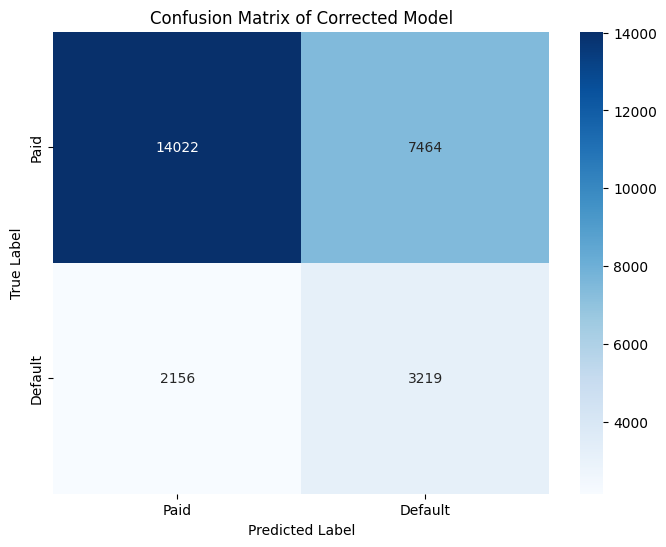


--- Project Nova Corrected Model Pipeline Finished ---


In [8]:
print("\n--- Step 1 & 2: Loading and Preprocessing Data ---")
try:
    df_full = pd.read_csv('project_nova_dataset.csv', low_memory=False)
    df = df_full.sample(frac=0.1, random_state=42)
    features_to_use = [
        'loan_status', 'loan_amnt', 'term', 'purpose', 'home_ownership', 
        'annual_inc', 'emp_length', 'dti', 'revol_util', 
        'inq_last_6mths', 'pub_rec_bankruptcies'
    ]
    df = df[features_to_use].copy()
    df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
    df['loan_status'] = np.where(df['loan_status'] == 'Charged Off', 1, 0)
    df['term'] = df['term'].str.extract('(\d+)').astype(int)
    emp_map = {'< 1 year': 0.5, '1 year': 1, '2 years': 2, '3 years': 3, '4 years': 4,
               '5 years': 5, '6 years': 6, '7 years': 7, '8 years': 8, '9 years': 9,
               '10+ years': 10}
    df['emp_length'] = df['emp_length'].map(emp_map)
    df['emp_length'].fillna(0, inplace=True)
    df['revol_util'].fillna(0, inplace=True)
    df['pub_rec_bankruptcies'].fillna(0, inplace=True)
    df['dti'].fillna(df['dti'].median(), inplace=True)
    inc_cap = df['annual_inc'].quantile(0.995)
    df['annual_inc'] = df['annual_inc'].clip(upper=inc_cap)
except FileNotFoundError:
    print("Error: 'project_nova_dataset.csv' not found.")
    exit()

# =============================================================================
# 3. FEATURE ENGINEERING AND DATA PREPARATION (No Changes)
# =============================================================================
print("\n--- Step 3: Engineering Features and Preparing Data ---")
df['loan_to_income_ratio'] = df['loan_amnt'] / (df['annual_inc'] + 1)
df['credit_stress_indicator'] = df['dti'] * df['revol_util']
df = pd.get_dummies(df, columns=['home_ownership', 'purpose'], drop_first=True)
X = df.drop('loan_status', axis=1)
y = df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =============================================================================
# 4. ROBUST MODEL TRAINING (SIMPLIFIED AND CORRECTED)
# =============================================================================
print("\n--- Step 4: Training a Robust, Balanced Model ---")

# --- Calculate scale_pos_weight to handle class imbalance ---
num_neg = y_train.value_counts()[0]
num_pos = y_train.value_counts()[1]
scale_pos_weight_value = num_neg / num_pos
print(f"Calculated scale_pos_weight: {scale_pos_weight_value:.2f}")

# --- Use a reliable set of parameters ---
# We are removing the complex Optuna search for now to ensure stability
model_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'seed': 42,
    'n_jobs': -1,
    'verbose': -1,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'scale_pos_weight': scale_pos_weight_value # This is the most important parameter
}

model = lgb.LGBMClassifier(**model_params)

# Train with early stopping to prevent overfitting
model.fit(X_train, y_train,
          eval_set=[(X_test, y_test)],
          eval_metric='auc',
          callbacks=[lgb.early_stopping(100, verbose=False)])

print("Model training complete.")

# =============================================================================
# 5. FINAL MODEL EVALUATION (SIMPLIFIED AND CORRECTED)
# =============================================================================
print("\n--- Step 5: Evaluating the Final Model ---")

# --- Make predictions using the default 0.5 threshold ---
# The scale_pos_weight already adjusts the model's learning, 
# so we can evaluate it directly without finding a new threshold.
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# --- Evaluation ---
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

print("\n--- ROC-AUC Score ---")
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"The ROC-AUC score for the model is: {auc_score:.4f}")

# --- Plot Confusion Matrix ---
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Paid', 'Default'],
            yticklabels=['Paid', 'Default']) # Corrected labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Corrected Model')
plt.show()

print("\n--- Project Nova Corrected Model Pipeline Finished ---")